In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

In [2]:
search = lk.search_lightcurve('U Gru', cadence=120)
lc = search[-1].download().remove_nans().remove_outliers().normalize()

/home/colej/software/miniconda3/envs/nominal/lib/python3.9/site-packages/lightkurve/lightcurve.py:1131: LightkurveWarning: The light curve appears to be zero-centered (median=7.51e+03 ppm +/- 1.53e+05 ppm); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(


<IPython.core.display.Javascript object>


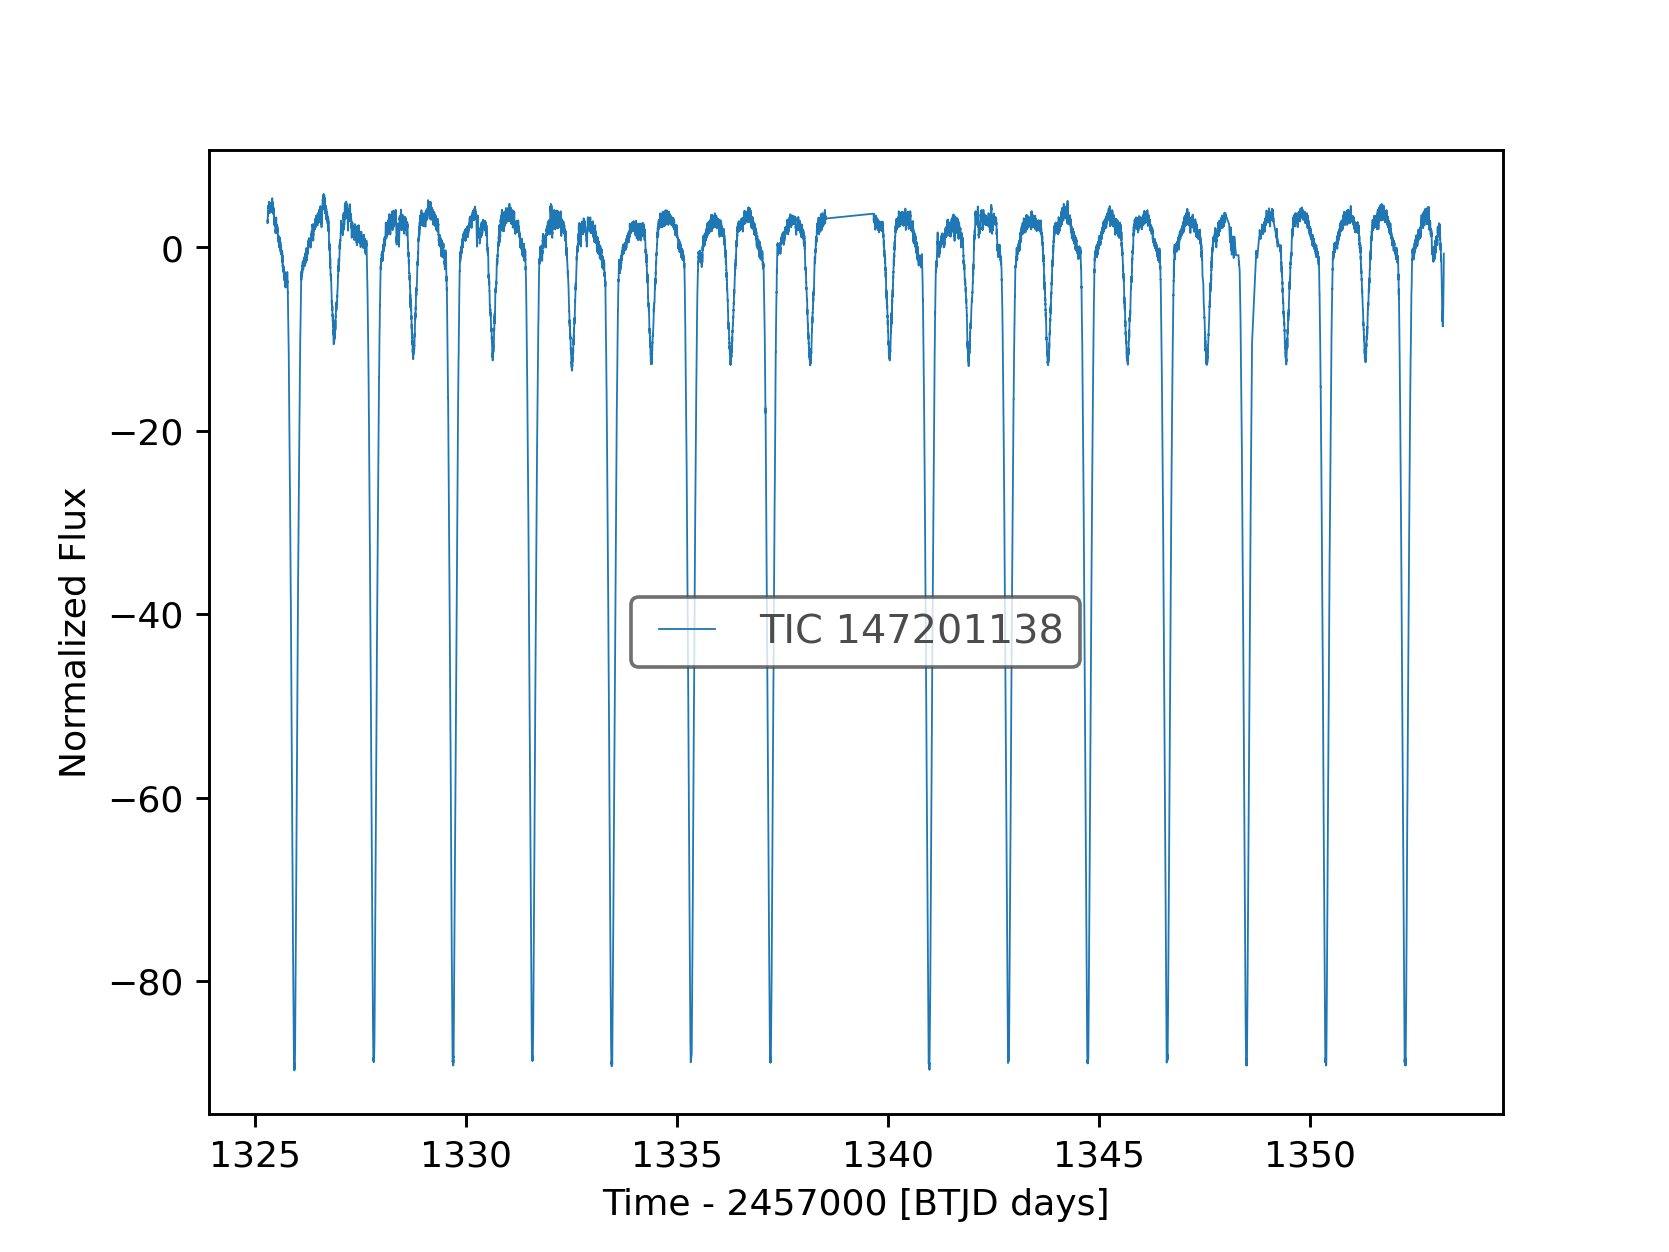

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

In [3]:
fig_lc, ax_lc = plt.subplots(num=1)
lc.plot(ax=ax_lc)

<IPython.core.display.Javascript object>


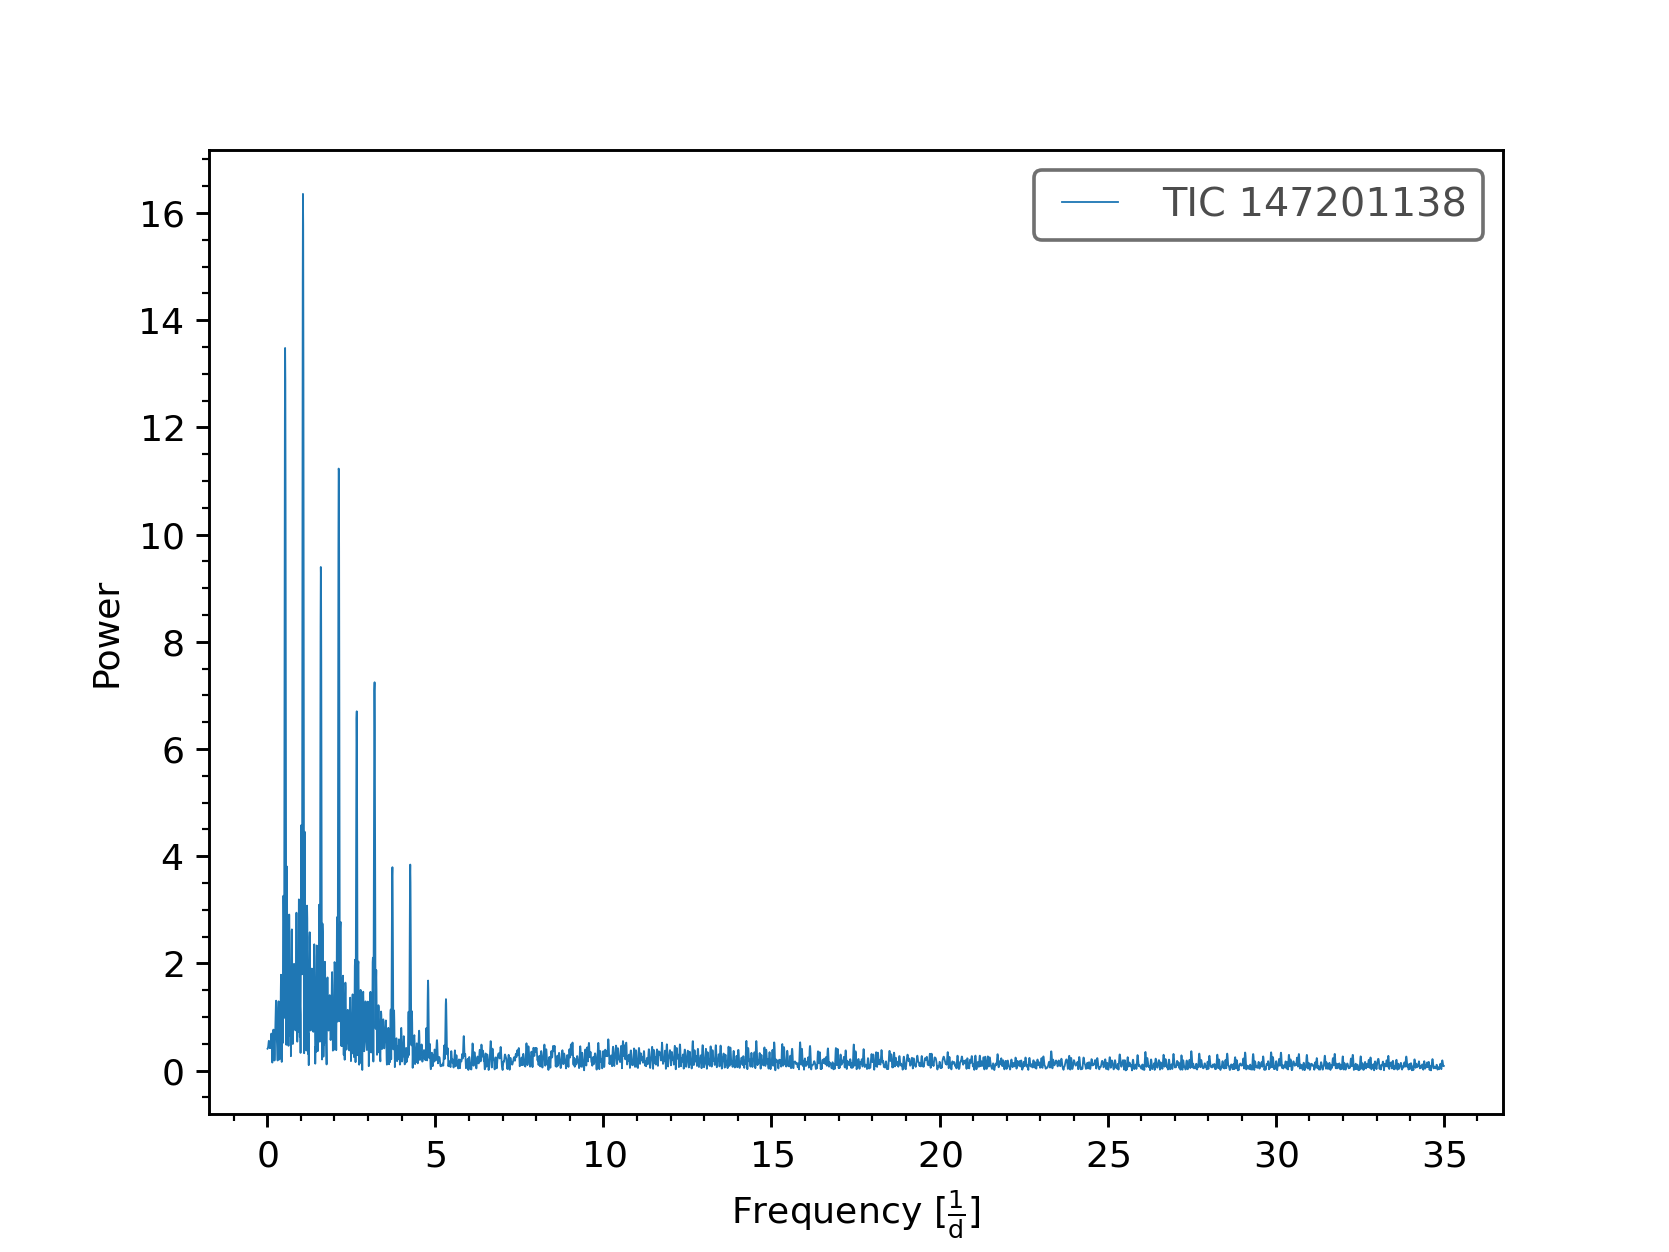

In [4]:
ls = lc.to_periodogram(maximum_frequency=35)
fig, ax = plt.subplots(num=2)
ls.plot(ax=ax)
plt.show()

In [5]:
period = 1.8805
time = lc.time.value
flux = lc.flux.value
ferr = lc.flux_err.value

In [6]:
p2 = 2./ls.frequency.value[np.argmax(ls.power.value)]

In [7]:
def design_matrix(ts, T, n_modes):
    omegas = 2. * np.pi * np.arange(1, n_modes + 1) / T
    X = np.zeros((len(ts), 2 * n_modes))
    X[:,::2] = np.cos(omegas[None, :] * ts[:, None]) # I'm dyin heah
    X[:,1::2] = np.sin(omegas[None, :] * ts[:, None])
    return X

In [12]:
K = 50
X = design_matrix(time, period, K)
print(X.shape)
print(flux.shape)
print(time.shape)
amps = np.linalg.solve(X.T @ X, X.T @ flux)
# amps, resids, rank, S = np.linalg.lstsq(X, flux, rcond=None)

(18103, 100)
(18103,)
(18103,)


In [13]:
synth = X @ amps
resid = flux - synth

In [14]:
from pythia.timeseries.lombscargle import LS_periodogram

nu, amp = LS_periodogram(time, resid, max=35)
print(resid, amp)

[-7.00687823 -6.89399503 -6.56823891 ...  0.61364893  1.55033047
  3.3021835 ] [0.10291146 0.10680054 0.11068261 ... 0.00688104 0.00417799 0.00160291]


<IPython.core.display.Javascript object>


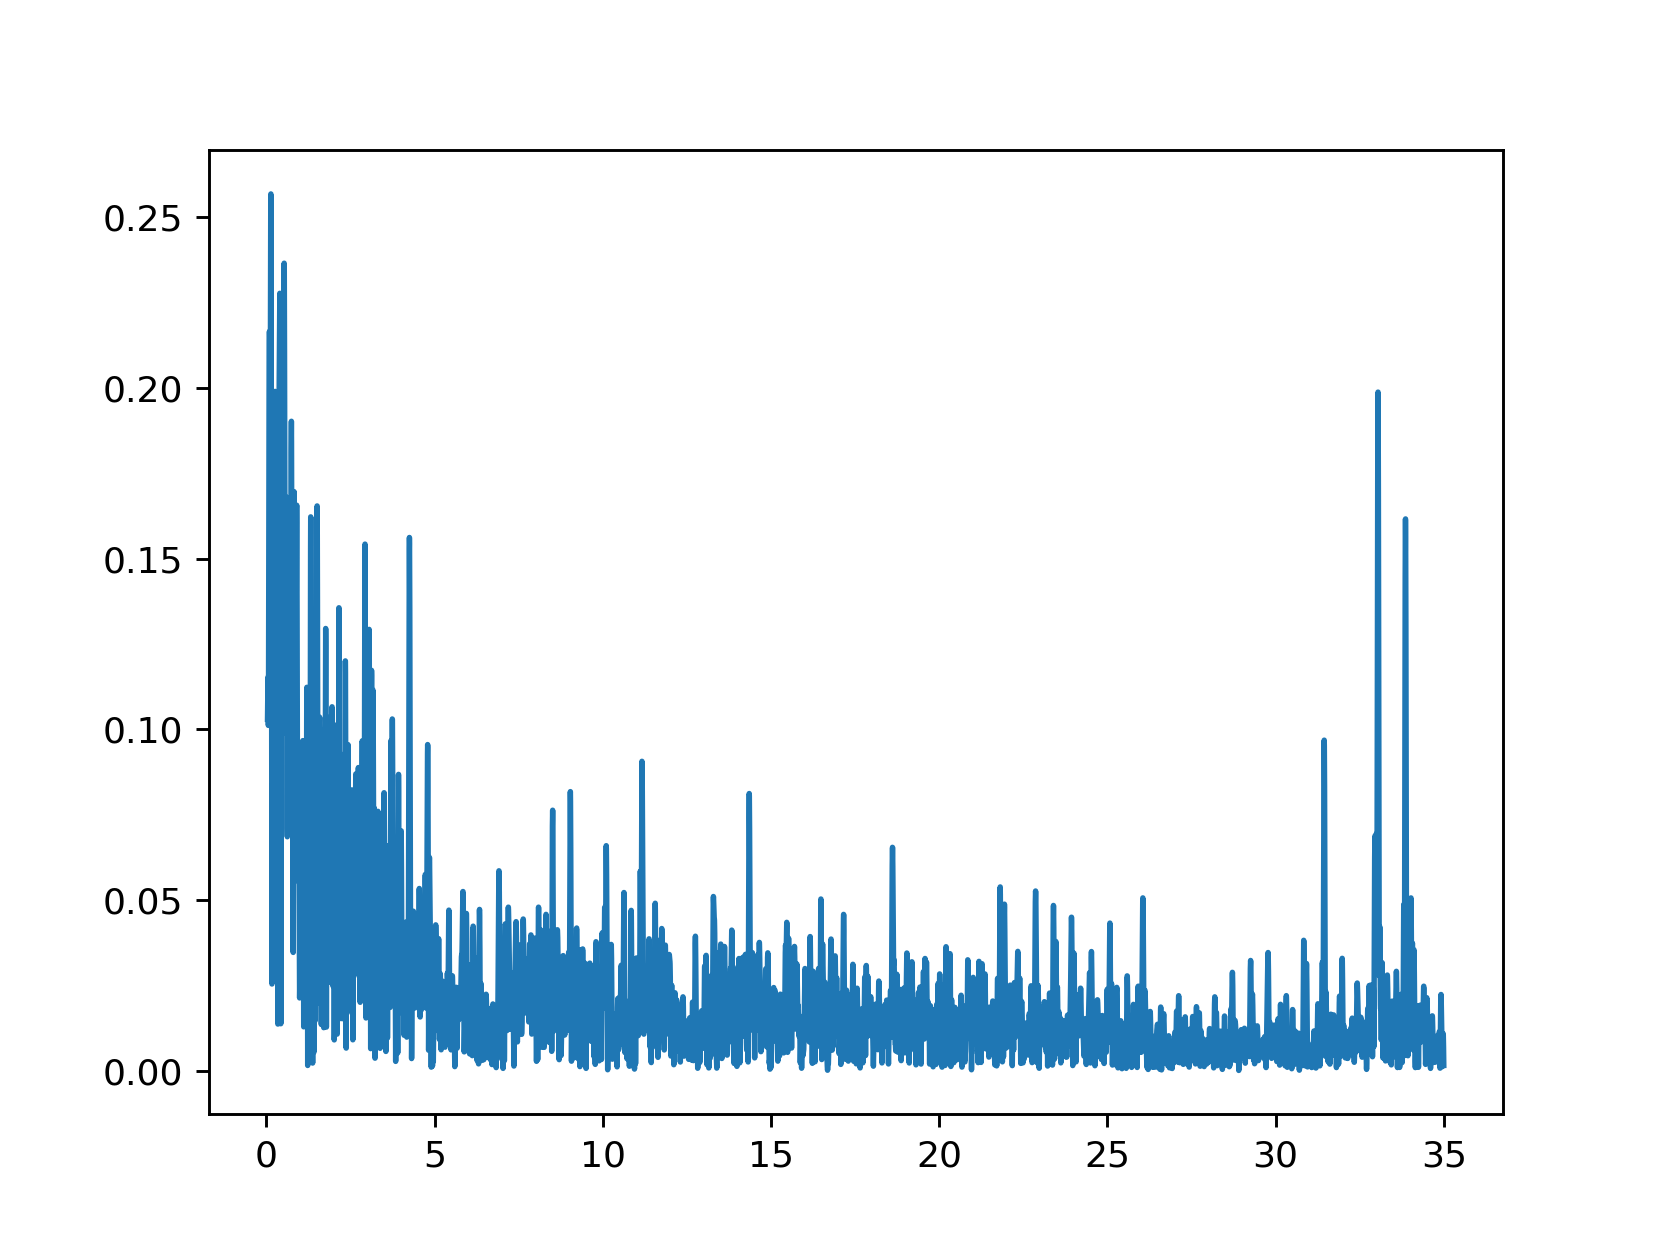

In [15]:
fig_, ax_ = plt.subplots(num=7)
ax_.plot(nu, amp)